In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_321200/388590871.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [4]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

# Substrategies

We've already identified some substrategies in the way the suggestion bar is used. In this section we examine how common these sub-strategies are and for which words they are used.

### Data prep

In [5]:
words = pd.read_csv('./data/words.csv')

In [6]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [7]:
participants = pd.read_csv('./data/participants_processed.csv',index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

### What is the prevalence of the sub-strategies?

#### What is the prevalence over all words?

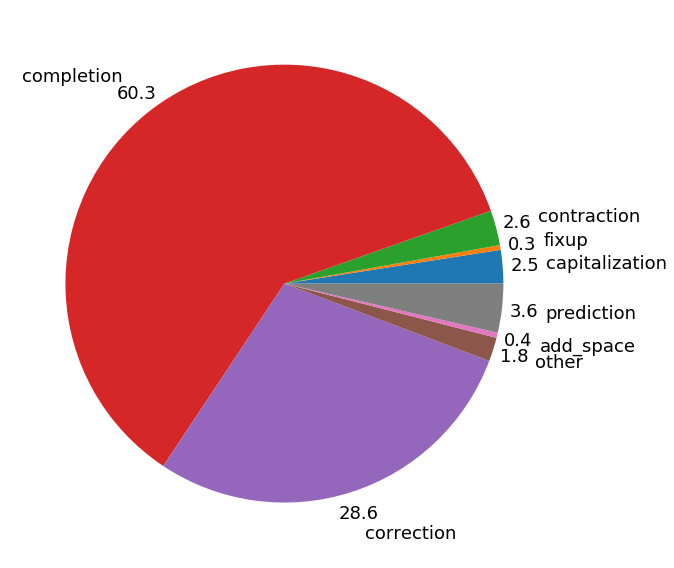

In [7]:
f,ax = plt.subplots(1,1,figsize=(12,8))

data = words.loc[~words.ite2.isin(['no_change','none'])]
data.ite2.value_counts(normalize=True).sample(frac=1,random_state=4).plot.pie(autopct='%.1f',labeldistance=1.2,pctdistance=1.1,fontsize=18,radius=1,ax=ax)
ax.set_aspect('equal')
ax.set_ylabel('')
f.tight_layout()
f.savefig('./figures/pie_substrategies.png',dpi=300)

#### How does the prevalence change for capital and contraction words?

In [8]:
words.groupby('type').ite2.value_counts(normalize=True)

type         ite2          
contraction  contraction       0.489334
             completion        0.384414
             correction        0.104919
             other             0.011319
             prediction        0.004354
             capitalization    0.003918
             fixup             0.001741
generic      completion        0.625674
             correction        0.303428
             prediction        0.041105
             other             0.017777
             add_space         0.004431
             fixup             0.003649
             capitalization    0.002607
             no_change         0.000808
             contraction       0.000521
proper       completion        0.511986
             capitalization    0.226594
             correction        0.225237
             other             0.018770
             prediction        0.008593
             contraction       0.004297
             fixup             0.002940
             no_change         0.001357
            

#### What is the prevalence of select-and-modify strategies?

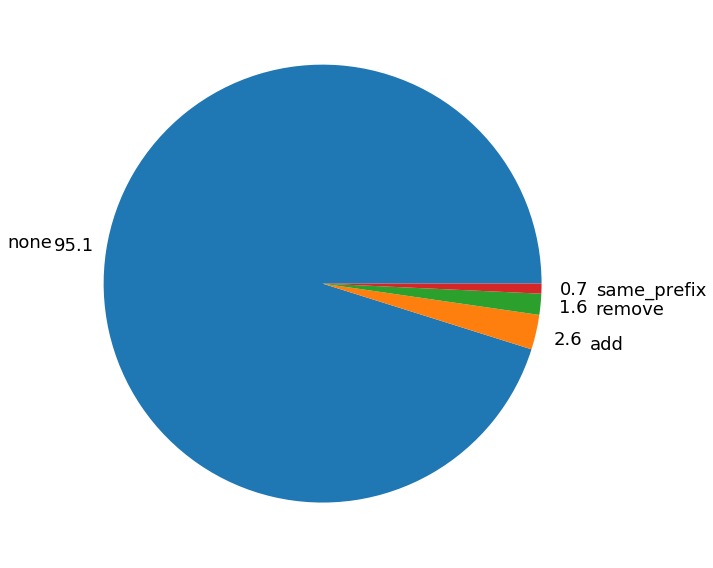

In [9]:
f,ax = plt.subplots(1,1,figsize=(8,8))

data = words.loc[words.ite == 'predict'].copy()
# For our purposes, "other"-type strategic entries are treated as "none"
data.loc[data.strategic == 'other','strategic'] = 'none'
data.strategic.value_counts(normalize=True).plot.pie(autopct='%.1f',labeldistance=1.25,pctdistance=1.15,fontsize=18,radius=1,ax=ax)

ax.set_aspect('equal')
ax.set_ylabel('')
f.tight_layout()

f.savefig('./figures/pie_strategic.png',dpi=300)

In [10]:
words.loc[words.strategic != 'none'].strategic.value_counts(normalize=True)

add            0.378113
other          0.285387
remove         0.228375
same_prefix    0.108126
Name: strategic, dtype: float64

In [11]:
# Prevalnence not including "none"
words.strategic.value_counts(normalize=True).iloc[1:].sum()

0.0679021959196387

### What words are most commonly associated with a given strategy?

#### Data prep

In [12]:
data = words.copy()
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['none','completion','correction'])] # Focus on completion and correction
data = data.groupby('word').filter(lambda x: x.shape[0] > 20).groupby(['word']).ite2.value_counts(normalize=True) # Only include words that occured more than 20 times

#### What are the most common words for completion and correction?

In [13]:
data.unstack().sort_values('correction',ascending=False).head(20)

ite2,completion,correction,none
word,,,
kilometres,0.125000,0.500000,0.375000
Azerbaijan,0.315789,0.456140,0.228070
humor,0.074074,0.296296,0.629630
centre,0.015385,0.261538,0.723077
labour,0.017241,0.241379,0.741379
Rao,NaN,0.200000,0.800000
separately,0.278481,0.177215,0.544304
defence,NaN,0.166667,0.833333
I'lol,NaN,0.164384,0.835616


In [14]:
data.unstack().sort_values('completion',ascending=False).head(20)

ite2,completion,correction,none
word,,,
inconvenience,0.585034,0.054422,0.360544
productivity,0.571429,0.043956,0.384615
indefinitely,0.487805,0.085366,0.426829
organization,0.458333,0.125000,0.416667
unnecessary,0.442857,0.014286,0.542857
immediately,0.438202,0.089888,0.471910
parliamentary,0.432836,0.089552,0.477612
demonstrations,0.424242,0.045455,0.530303
administration,0.423077,0.025641,0.551282


### How is the probability of using a sub-strategy affected by: word length, word frequency, etc.

#### How does word length affect sub-strategy usage?

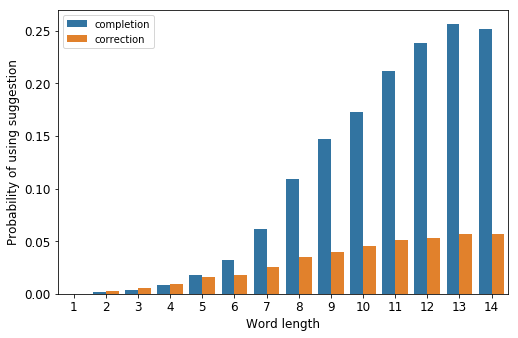

In [15]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

### Data prep ###
data = words.loc[words.word_length < 15].copy() 
data.ite2 = data.ite2.fillna('none')
# For each word length, get the relative prevalence of each substrategy
data = data.groupby('word_length').ite2.value_counts(normalize=True)
data = data.reset_index(name='probability')
# Focus on completion and correction
data = data.loc[data.ite2.isin(['completion','correction'])]

### Plot ###
data = data.sort_values('ite2') # Sort to get a consistent order
sns.barplot('word_length','probability','ite2',data=data,ax=ax)

ax.set_xlabel('Word length')
ax.set_ylabel('Probability of using suggestion')
ax.set_xticklabels(range(1,15))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

f.tight_layout(pad = 0)
f.savefig('./figures/bar_word_length.png', dpi=300)

#### How does word frequency affect sub-strategy usage?

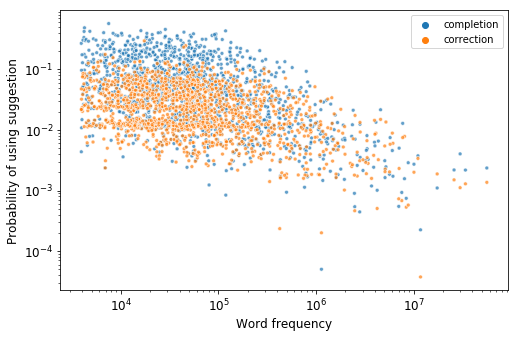

In [16]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

### Data prep ###
data = words.copy()
data.ite2 = data.ite2.fillna('none')
# Only include words with frequencies that appear more than 20 times in the dataset (for better probability estimation) 
data = data.groupby('freq').filter(lambda x: x.shape[0] > 20)
# For each frequency, get the relative prevalence of each substrategy
data = data.groupby(['freq']).ite2.value_counts(normalize=True)
data = data.reset_index(name='probability')
# Focus on completion and correction
data = data.loc[data.ite2.isin(['completion','correction'])]

### Plot ###
data = data.sort_values('ite2')
ax.set_xscale('log')
ax.set_yscale('log')
sns.scatterplot('freq','probability','ite2',data=data,s=15,alpha=0.7,ax=ax)

ax.set_xlabel('Word frequency')
ax.set_ylabel('Probability of using suggestion')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

f.tight_layout(pad = 0)

f.savefig('./figures/scatter_word_frequency.png', dpi=300)

#### What does leadup speed tell us about sub-strategy usage?

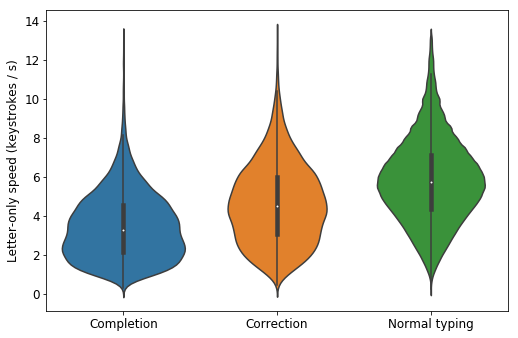

In [17]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

### Data prep ###
data = words.loc[(words.word_length > 2) & (words.word_length < 15)].copy()
data.ite2 = data.ite2.fillna('none')
# Focus on completion, correction, and normal typing
data = data.loc[data.ite2.isin(['none','completion','correction'])]
# Remove outliers (words typed extremely quickly)
data = data.loc[data.iki_letters > 75]
# Convert iki to speed
data['speed'] = data.iki_letters.apply(np.reciprocal)*1000

### Plot ###
data = data.sort_values('ite2')
sns.violinplot('ite2','speed',data=data, ax=ax)

ax.set_xticklabels(['Completion','Correction','Normal typing'])
ax.set_xlabel('')
ax.set_ylabel('Letter-only speed (keystrokes / s)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/violin_speed.png',dpi=300)

In [18]:
stats.ttest_ind(data.loc[data.ite2 == 'none'].speed,data.loc[data.ite2 == 'completion'].speed)

Ttest_indResult(statistic=175.53722062140463, pvalue=0.0)

In [19]:
stats.ttest_ind(data.loc[data.ite2 == 'none'].speed,data.loc[data.ite2 == 'correction'].speed)

Ttest_indResult(statistic=62.64272771538245, pvalue=0.0)

In [20]:
stats.ttest_ind(data.loc[data.ite2 == 'completion'].speed,data.loc[data.ite2 == 'correction'].speed)

Ttest_indResult(statistic=-57.986491398277636, pvalue=0.0)

### What are the relative importances of word length, word frequency, etc.?

#### Data prep

In [21]:
mask = words.ite.isin(['none','predict']) # Ignore autocorrected words
mask &= (words.word == words.ite_input) | (words.ite == 'none') # Only include words whose ite_input is the same as the final word (to avoid accidental suggestion usage)
mask &= words.word_length > 1 # Cannot detect suggestion for one-letter words
mask &= words.word_length < 14 # Not enough data for very long words
mask &= words.iki_letters > 30 # Remove outlier words that were typed extremely quickly
data = words.loc[mask,['word','word_length','freq','iki_letters','ite2']].copy() # Focus on word length, word frequency, and leadup speed

# Convert iki to leadup speed
data['leadup_speed'] = data.iki_letters.apply(np.reciprocal)*1000
data.drop('iki_letters',axis=1,inplace=True)

# Focus on correction and completion
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['none','correction','completion'])]

data.set_index('word',inplace=True)
data = data.dropna()

# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Preprocess y
y = data['ite2'].copy()

#### Logistic regression

In [22]:
# Helper to add asterix based on p-value
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

params = []
params_disp = []
X = sm.add_constant(X)

# For each sub-strategy
for i in y.sort_values().unique():
    if i == 'none':
        continue # Remove this to also calculate the probability of typing normally
        model = sm.Logit((y != i).astype(float),X)
    # Logistic regression
    model = sm.Logit((y == i).astype(float),X)
    results = model.fit(method='lbfgs',maxiter=1000)
    
    # Prepare a nice table of coefficients (add asterix, stderr, etc.)
    a = results.params
    for param,val in results.params.iteritems():
        a.loc[param] = '{}{}\n({})'.format(
            str(round(val,2)),
            to_asterix(results.pvalues.loc[param]),
            str(round(results.bse.loc[param],2))
        )
    params.append(results.params.to_frame(i)) # This is the parameters as numbers (without formatting)
    params_disp.append(a.to_frame(i)) # This is the parameters with asterux, etc.

# Create overall dataframe of parameters
params = pd.concat(params,axis=1,sort=False)
params_disp = pd.concat(params_disp,axis=1,sort=False)
params_disp = params_disp.fillna('N/A')

In [23]:
from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(params_disp.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


,completion,correction
const,-5.5*** (0.02),-4.87*** (0.02)
word_length,1.02*** (0.01),0.5*** (0.01)
freq,-0.33*** (0.03),-0.67*** (0.04)
leadup_speed,-1.63*** (0.01),-0.37*** (0.01)


### What edit distance is associated with each compeltion vs. correction

#### Data prep

In [24]:
mask = (words.ite_input == words.word)
mask &= (words.ite_lev_dist <= words.ite_input_len) # Remove outlier extremely large levenshtein distances
mask &= words.word_length > 1 # Cannot detect sugggestion on one-letter words
mask &= words.word_length < 13 # Remove long words (no enough data)
mask &= words.ite_lev_dist > 0 # Ignore 0-LD changes

# Matrix for completion
data = words.loc[(words.ite2 == 'completion') & mask]
section1 = data.word_length
section2 = data.ite_lev_dist
matrix1 = data.groupby([section1,section2]).size().unstack().fillna(0)
matrix1 = matrix1.div(matrix1.sum(axis=1),axis=0) # Normalize rows

# Matrix for correction
data = words.loc[(words.ite2 == 'correction') & mask]
section1 = data.word_length
section2 = data.ite_lev_dist
matrix2 = data.groupby([section1,section2]).size().unstack().fillna(0)
matrix2 = matrix2.div(matrix2.sum(axis=1),axis=0) # Normalize rows

#### Heatmaps

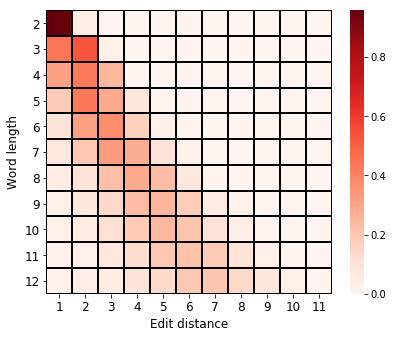

In [25]:
f,ax = plt.subplots(1,1,figsize=(5.5,4.5))

sns.heatmap(matrix1,ax=ax,cmap='Reds',linewidths=1,linecolor='k')

ax.set_yticklabels(range(2,13))
ax.set_xticklabels(range(1,12))
ax.set_ylabel('Word length')
ax.set_xlabel('Edit distance')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/heatmap_completion.png',dpi=300)

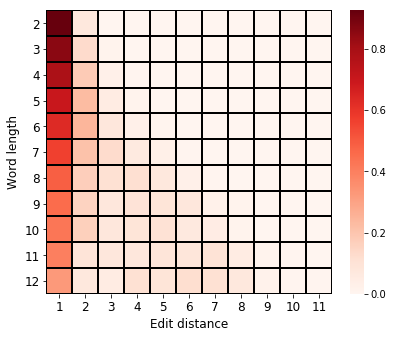

In [26]:
f,ax = plt.subplots(1,1,figsize=(5.5,4.5))

sns.heatmap(matrix2,ax=ax,cmap='Reds',linewidths=1,linecolor='k')

ax.set_yticklabels(range(2,13))
ax.set_xticklabels(range(1,12))
ax.set_ylabel('Word length')
ax.set_xlabel('Edit distance')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/heatmap_correction.png',dpi=300)

In [27]:
words.loc[(words.ite2 == 'completion') & mask & (words.word_length == 10)].ite_lev_dist.median()

5.0

In [28]:
words.loc[(words.ite2 == 'correction') & mask & (words.word_length == 10)].ite_lev_dist.median()

2.0